In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import torch.nn.functional as F
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c
#plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# here's the good stuff...
import torch
import torch.nn as nn
from torch.autograd import Variable

from PIL import Image

import torchvision
import torchvision.transforms as transforms

# Cancer Images

Let's first get the images and labels:

In [9]:
import os
files=os.listdir('breastpathq/datasets/train')
example = Image.open('breastpathq/datasets/train/99788_1.tif')
example.show()

import csv
with open('breastpathq/datasets/train_labels.csv') as f:
    train_labels=csv.reader(f)
    labels=[]
    for i in train_labels:
        labels.append(i)
        
images=[]
for f in files:
    im = Image.open('breastpathq/datasets/train/'+f)
    image_np=np.array(im).transpose(2,1,0)
    images.append(image_np)
    im.close()
    
images=np.array(images)
new_labels=torch.tensor(np.array(labels[1:])[:,2].astype(np.float)).float()

Now we build a completely arbitrary neural network just to get started.  This wasn't well thought out.  I just want something that takes in an images (i.e., a (3,512,512) tensor) and spits out a number, i.e., the percentage of the slide that is cancer.  We can figure out how to improve this later.

In [15]:
import torch.nn.functional as F
class Cancer(nn.Module):
    def __init__(self):
        super(Cancer, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.new=nn.Conv2d(16,1,125)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
    def forward(self, x):
        x=torch.tensor(x).type('torch.DoubleTensor')
        x = self.pool(self.conv1(x.float()))
        x = self.pool(F.relu(self.conv2(x)))
        x=torch.sigmoid(self.new(x).view(-1))
        return x

Next we instantiate the class and create a loss function.  I will be using the MSE loss between the true percentages and the predicted percentages.

In [16]:
cancer=Cancer()
criterion=nn.MSELoss()
optimizer = torch.optim.SGD(cancer.parameters(), lr=0.001, momentum=0.9)

Now let's train!  I'll divide this up into batches of size 10.  Again, there is no rhyme or reason here and these choices should be carefully reconsidered in the future.

In [17]:
batch_size=10
losses=[]
for i in range(images.shape[0]//batch_size):
    # get the inputs
    inputs=images[batch_size*i:batch_size*i+batch_size,:,:,:]
    percentages=new_labels[batch_size*i:batch_size*i+batch_size]

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = cancer(inputs)
    loss = criterion(outputs, percentages)
    numerical_loss=loss.detach().numpy()
    losses.append(numerical_loss)

    print(numerical_loss)
    loss.backward()
    optimizer.step()

0.31973863
0.02682
0.00034
0.05949
0.012290001
0.0
0.0065000006
0.01908
0.008
0.11
0.22425
0.0975
0.05625
0.17225
0.058250003
0.19975
0.012
0.16774999
0.22704
0.22225
0.26725
0.95696
0.26225
0.11175
0.03951
0.66554004
0.2565
0.2015
0.07124
0.19025001
0.011000001
0.09738
0.15
0.051000003
0.1385
0.12525
0.073750004
0.0
0.73985
0.4565
0.092250004
0.50101
0.80925
0.256
0.023
0.82929
0.39375
0.042
0.83749
0.53859
0.1805
0.113740005
0.035
0.0
0.69579
0.29925
0.1385
0.1435
0.01499
0.0
0.42575002
0.3635
0.156
0.084
0.01675
0.0
0.0
0.3395
0.45775
0.45825002
0.222
0.087500006
0.0245
0.0
0.12200001
0.09675
0.139
0.0
0.0
0.319
0.16025001
0.04075
0.052750003
0.008
0.006
0.019590002
0.00229
0.60102
0.34100002
0.12999001
0.014250001
0.39725
0.44149998
0.1525
0.023000002
0.0038400001
0.15734
0.0
0.0
0.0
0.093499996
0.00694
0.0064700004
0.0
0.0
0.0
0.0
0.21824999
0.5005
0.28724998
0.132
0.63625
0.26
0.14750001
0.06475
0.435
0.3735
0.12300001
0.024740001
0.19604
0.67338
0.257
0.1175
0.0
0.0
0.57483
0.0


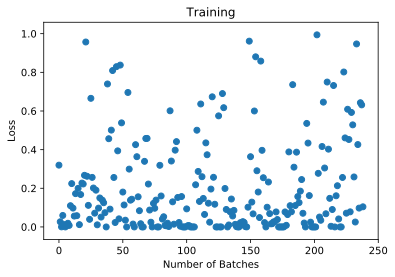

In [22]:
plt.scatter(range(len(losses)),losses)
plt.xlabel("Number of Batches")
plt.ylabel("Loss")
plt.title("Training")
plt.show()